# **Prototype - Finding Straight Lane Lines on the Road** 
***
Welcome to the Gentle CV Intro for Self-Driving Car. We are going to use the tools we discussed earlier to identify **straight** lane lines on the road. That is the goal of this notebook. We will prototype a simple UI in order to help us identify what the best method to find straight lane lines on the road.

We will develop series of pipeline using openCV and we might be able to apply the later result to video stream.

Check out [CS231n Python for basics](http://cs231n.github.io/python-numpy-tutorial/). It gives really good amount of tutorial for doing things with **numpy**. 

---
Without further due, let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

Here's what we are trying to build 

<figure>
 <img src="assets/FinalBuild.jpeg" width="500" alt="Final Prototype" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your prototype should look something like above</p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="assets/UI_example.jpeg" width="500" alt="UI Prototype" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> If there is no image gets selected, our starter code will show like above</p> 
 </figcaption>
</figure>

### Let's import some libraries here

We will use numpy, sys, itertools, common Python library, openCV and matplotlib. If you have any issue getting this library you might consider to create new Python environment through **conda**


In [2]:
import numpy as np
import sys
import itertools
import os
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Load image here

There are several **test_images** you can find to start prototyping.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


270

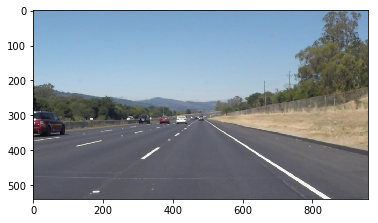

In [77]:
#reading in an image
img = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(img), 'with dimesions:', img.shape)
plt.imshow(img)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
img.shape[0] // 2

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. We will use it to build the prototype! Some guides toward filling the blank for exercises.

1. Try to fill the blank for **detect_lle** function

2. You need to find edges by applying COLOR_RGB2GRAY, and Gaussian Blur then CannyEdge

3. Apply mask with the vertices defined

4. Apply cv2.HoughLinesP

5. Replace with empty iterable if no lines were found

6. Infer lanes from line segments
 

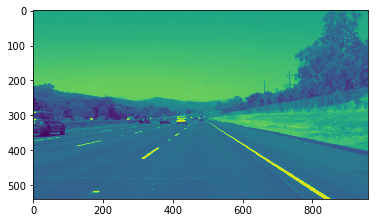

In [57]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray)

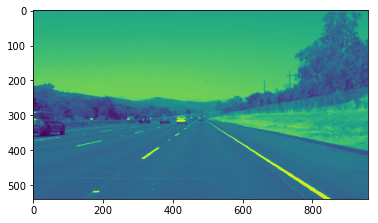

In [58]:
blur_img = cv2.GaussianBlur(img_gray,(5,5),0);
plt.imshow(blur_img)



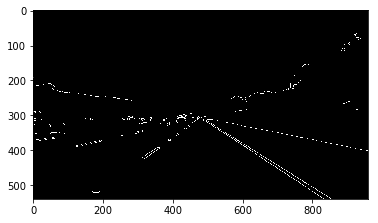

In [59]:
edges = cv2.Canny(blur_img, 100, 200)

plt.imshow(edges,cmap = 'gray')

In [69]:
TOL = 1e-6
N_FLAGS = 3 # number of flags that control image generation, see make_img

def apply_mask(img, vertices):
    """Apply mask to image if vertices of mask are defined."""
    if vertices is None:
        return img
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    imshape = img.shape
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    return cv2.bitwise_and(img, mask)


def draw_lines(img, lines, color = (255, 0, 0), thickness = 2):
    """Draw lines onto img."""
    if thickness > 0:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def lines_to_lanes(lines, y_bottom, y_middle):
    """Infer lanes from the given lines. **lines to lanes function
    Filter out horizontal line segments, extrapolate line segment such that 
    it goes from y_bottom to y_middle on the y component, seperate line segments for left lane 
    from those for right lane and finally take the median of the x components of 
    the points defining the line."""
    
    left_lane_bottoms = []
    left_lane_middles = []
    right_lane_bottoms = []
    right_lane_middles = []

    for line in lines:
        px, py, qx, qy = line[0]
        length = np.sqrt((qx - px)**2 + (qy - py)**2)
        # only accept lines that are neither vertical nor horizontal
        if((np.abs(qx - px) / length > TOL) and
                (np.abs(qy - py) / length > TOL)):
            lambda_middle = (y_middle - py) / (qy - py)
            lambda_bottom = (y_bottom - py) / (qy - py)

            x_middle = np.round(px + lambda_middle * (qx - px)).astype(int)
            x_bottom = np.round(px + lambda_bottom * (qx - px)).astype(int)

            # decide which lane this line corresponds to by looking at the
            # quadrant in which the line is
            if (qx > px and qy > py) or (qx < px and qy < py):
                # first or third quadrant is left lane
                left_lane_bottoms.append(x_bottom)
                left_lane_middles.append(x_middle)
            else:
                # second and fourth quadrant is right lane
                right_lane_bottoms.append(x_bottom)
                right_lane_middles.append(x_middle)

    # take the medians for final decision and return a result that is
    # compatible with the structure returned by HoughLinesP, i.e. a sequence
    # of lines each being a sequence of x1,y1,x2,y2 where (x1,y1) and
    # (x2, y2) determine the line.
    lanes = []
    if left_lane_bottoms:
        x_bottom_left = np.round(np.median(left_lane_bottoms)).astype(int)
        x_middle_left = np.round(np.median(left_lane_middles)).astype(int)
        lanes.append([(x_bottom_left, y_bottom, x_middle_left, y_middle)])
    if right_lane_bottoms:
        x_bottom_right = np.round(np.median(right_lane_bottoms)).astype(int)
        x_middle_right = np.round(np.median(right_lane_middles)).astype(int)
        lanes.append([(x_bottom_right, y_bottom, x_middle_right, y_middle)])

    return lanes


def detect_lle(
        img,
        gauss_kernel_size,
        canny_low_threshold, canny_high_threshold,
        hough_rho, hough_theta, hough_threshold,
        hough_min_line_length, hough_max_line_gap,
        vertical_lane_offset = 50,
        mask_vertices = None, **kwargs):
   
    """Find lanes, lines and edges of img."""
    
    # Verify sure gaussian kernel size is odd
    if gauss_kernel_size % 2 == 0:
        gauss_kernel_size += 1
        
    ################# Assignment starts here ########################
 
    #1. You need to find edges by applying COLOR_RGB2GRAY, and Gaussian Blur then CannyEdge
    edges = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.GaussianBlur(edges,gauss_kernel_size,0);
    edges = cv2.Canny(edges, canny_low_threshold, canny_high_threshold);
    

    #2. Apply mask with the vertices defined
    edges = apply_mask(edges, mask_vertices);
    
    
    #3. Apply cv2.HoughLinesP
    lines = cv2.HoughLinesP(edges, hough_rho, hough_theta, hough_threshold, minLineLength=hough_min_line_length, maxLineGap = hough_max_line_gap)
    #4. Replace with empty iterable if no lines were found
    if lines == None:
        lines = []
    #draw_lines(masked_img, lines)
    #5. Infer lanes from line segments
    lanes = lines_to_lanes(lines, y_bottom, y_middle)
    ################################################################
    
    return lanes, lines, edges


def make_img(img, mode, **kwargs):
    """Make line image for the given img.
    
    kwargs are passed to detect_lle,
    mode is a bit flag to determine what is drawn:
    0-th bit: If set, use original image as background otherwise use edges
    1-th bit: If set draw lines detected in the image
    2-th bit: If set draw lanes detected in the image
    """
    lanes, lines, edges = detect_lle(img = img, **kwargs)

    background_bit = 0
    lines_bit = 1
    lanes_bit = 2

    # use either the original image or the edges of the image as canvas
    if mode & 1<<background_bit:
        base = np.copy(img)
    else:
        base = np.dstack(3*[edges])

    # draw lines and lanes on blank canvas
    bg = np.zeros_like(img)

    if mode & 1<<lines_bit:
        draw_lines(bg, lines, color = (255,0,0), thickness = 2)

    if mode & 1<<lanes_bit:
        draw_lines(bg, lanes, color = (0,0,255), thickness = 6)

    # combine base with lines
    return cv2.addWeighted(base, 0.8, bg, 1.0, 0.0)


def make_mask(image,
        mask_horizontal_aperture = 30,
        mask_vertical_adjustment = 50):
    """Generate vertices to be used as a mask.
    
    Bottom vertices are at the bottom corners of the image, the other two
    vertices are at the center of the image adjusted by the two parameters.
    """
    height, width = image.shape[:2]
    vertices = np.array([[
        (0, height - 1),
        ((width - 1) // 2 - mask_horizontal_aperture,
            (height - 1) // 2 + mask_vertical_adjustment),
        ((width - 1) // 2 + mask_horizontal_aperture,
            (height - 1) // 2 + mask_vertical_adjustment),
        (width - 1, height - 1)]],
        dtype=np.int32)
    return vertices

In [81]:

state = {
            "img": image,
            "result": None,
            "gauss_kernel_size": 3,
            "canny_low_threshold": 50,
            "canny_high_threshold": 150,
            "hough_rho": 1,
            "hough_theta": 1,
            "hough_threshold": 40,
            "hough_min_line_length": 5,
            "hough_max_line_gap": 5,
            "mask_vertices": vertices,
            "mode": int("101", 2)}




In [84]:
#edges_img = cv2.Canny(blur_img, 100, 200)

#img_msk = apply_mask(edges_img, vertices);
#plt.imshow(edges_img)
vertices = make_mask(img)

vertices

array([[[  0, 539],
        [449, 319],
        [509, 319],
        [959, 539]]], dtype=int32)

In [64]:
#lines = cv2.HoughLinesP(edges_img, state['hough_rho'], state['hough_theta'], 
#                        state['hough_threshold'], 
#                        minLineLength=state['hough_min_line_length'], 
#                        maxLineGap = state['hough_max_line_gap'])

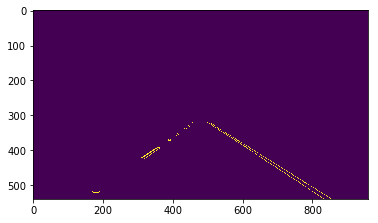

In [66]:
#draw_lines(img_msk, lines)
#plt.imshow(img_msk)

In [70]:
#lanes = lines_to_lanes(lines, 0, 300)
#lanes

## Continue on Images

Now we have the helper function filled out. Let's start to implement the UI function to work on the images in the directory "test_images"  

**You should make sure your pipeline works well on these images before you try running the UI.**

In [71]:
os.listdir("test_images/")

['.DS_Store',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [22]:
loop = True

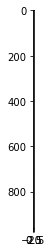

In [23]:
if __name__ == "__main__":
    
    if (not loop) and len(sys.argv) < 2:
        print("Useage: {} input_image.jpg [input_image2.jpg ...]".format(sys.argv[0]))
        print("Cycle through images with 'n'. Exit with 'q'.")
        exit(1)
        
        
    ##### ##### Uncomment the code below for reading set of images outside the Notebook ##### 
    #fnames = sys.argv[1:]
    # read input as list of images
    #images = []
    ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 
    
    # Read single image from upper definition
    images = img
    
    ##### ##### Uncomment the code below for reading set of images outside the Notebook ##### 
    #for fname in fnames:
    #    images.append(cv2.imread(fname))
    # print("Read {} images.".format(len(images)))
    ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 

    # Line finder
    image_cycle = itertools.cycle(images)
    image = next(image_cycle)
    plt.imshow(image)
    vertices = make_mask(image)
    state = {
            "img": image,
            "result": None,
            "gauss_kernel_size": 3,
            "canny_low_threshold": 50,
            "canny_high_threshold": 150,
            "hough_rho": 1,
            "hough_theta": 1,
            "hough_threshold": 40,
            "hough_min_line_length": 5,
            "hough_max_line_gap": 5,
            "mask_vertices": vertices,
            "mode": int("101", 2)}
    vertices = make_mask(image)

    # parameters exposed to ui together with maximum values
    ui_max_params = {
            "gauss_kernel_size": 50,
            "canny_low_threshold": 500,
            "canny_high_threshold": 500,
            "hough_threshold": 500,
            "hough_min_line_length": 500,
            "hough_max_line_gap": 500,
            "mode": (1 << N_FLAGS) - 1}

    # Create window to show result and controls
    cv2.startWindowThread()

    cv2.namedWindow("Line Detection", 0)

    def update(param, k, state):
        state[k] = param
        state["result"] = None

    for k in sorted(ui_max_params):
        cv2.createTrackbar(
                k, "Line Detection",
                state[k],
                ui_max_params[k],
                lambda param, k = k, state = state: update(param, k, state))
        
    # Main loop
    while True and loop:
        
        ##### Uncomment the code below after you have finished the def make_img #####  
        
        if state["result"] is None:
            state["result"] = make_img(**state)

        cv2.imshow("Line Detection", state["result"])
        
        ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 
        key = cv2.waitKey(1)
        if  key == ord('q'):
            # quit
            break
        elif key == ord('n'):
            # next image
            image = next(image_cycle)
            update(image, "img", state)
            update(make_mask(image), "mask_vertices", state)

## Reflections

Congratulations on building prototype finding the staright lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding experience specifically with some questions;

1. Why finding stairght lanes is important in self-driving car development ?

2. What are we building based on the CV Perception so far ? Summarize your work will be good for future reference

3. How could you imagine making your algorithm better / more robust?  

Please add your thoughts below,  and if you're up for making your pipeline more robust

## Answers

n
